# Milestone 2. and final submission

## Installing dependencies

In [1]:
%pip install -q torch dgl networkx pandas numpy

Note: you may need to restart the kernel to use updated packages.


## Setting hyperparameters

In [2]:
epochs = 100
features_num = 10
hidden1 = 64
hidden2 = 32
learning_rate = 0.05

In [3]:
# Set torch device
import torch

device = torch.device("cpu") # training on CPU because of runtime errors

## Defining the model according to the code from [`dmlc/dgl`](https://github.com/dmlc/dgl)

The code below will be taken from the reference implementation in the Deep Learning Graph Library (DGL). It follows the architecture shown in the source article.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv # must be installed with pip

class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim

        layers = [
            GraphConv(
                self.in_dim,
                self.hidden1_dim,
                activation=F.relu,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
        ]
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)
        self.mean = self.layers[1](g, h)
        self.log_std = self.layers[2](g, h)
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(
            device
        )
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(
            device
        )
        return sampled_z

    def decoder(self, z):
        adj_rec = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_rec

    def forward(self, g, features):
        z = self.encoder(g, features)
        adj_rec = self.decoder(z)
        return adj_rec

## Helper functions for data preprocessing 

In [5]:
import scipy.sparse as sp
import numpy as np

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj):
    # Remove diagonal elements
    adj = adj - sp.dia_matrix(
        (adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape
    )
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 10.0))
    num_val = int(np.floor(edges.shape[0] / 20.0))

    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val : (num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(
        edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0
    )

    def ismember(a, b, tol=5):
        rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    data = np.ones(train_edges.shape[0])

    # Re-build adj matrix
    adj_train = sp.csr_matrix(
        (data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape
    )
    adj_train = adj_train + adj_train.T

    return (
        adj_train,
        train_edges,
        val_edges,
        val_edges_false,
        test_edges,
        test_edges_false,
    )

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = (
        adj_.dot(degree_mat_inv_sqrt)
        .transpose()
        .dot(degree_mat_inv_sqrt)
        .tocoo()
    )
    return adj_normalized, sparse_to_tuple(adj_normalized)

## Loading our data

The `load_data` function uses our own data as reference. It expects the `data/` folder to have a `features.csv` (see Milestone I.)

In [6]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
import pandas as pd


def load_data():

    data = pd.read_csv("data/features.csv", header = None)
    data[0] = data[0].str.lstrip("D, B, 0")
    data[0] = data[0].astype('int')
    adj2 = data[0].copy()
    data = data.set_index(data.columns[0])
    sp.csr_matrix(data.values)

    graph2 = pd.read_csv("db/ChCh-Miner_durgbank-chem-chem.tsv.gz", header = None)
    graph = graph2.copy()
    graph[0] = graph2[0].str.split('\t').str[0]
    graph[1] = graph2[0].str.split('\t').str[1]
    graph[0] = graph[0].str.lstrip("D, B, 0")
    graph[0] = graph[0].astype('int')
    graph[1] = graph[1].str.lstrip("D, B, 0")
    graph[1] = graph[1].astype('int')
    graph

    adj = pd.DataFrame(adj2)
    adj = adj.set_index(adj.columns[0])
    adj[0] = np.empty((len(adj), 0)).tolist()

    for g in graph.iterrows():
        if g[1][0] in adj.index:
            if g[1][1] in adj.index:
                adj[0].loc[g[1][0]].insert(g[1][0],g[1][1])
                adj[0].loc[g[1][1]].insert(g[1][1],g[1][0])

    for a in adj.iterrows():
        if a[1][0] == []:
            adj = adj.drop(index = a[0])
            data = data.drop(index = a[0])

    features = sp.csr_matrix(data.values)/100.0
    adj_dict = pd.Series(adj[0], index = adj.index).to_dict()
    adjacency = nx.adjacency_matrix(nx.from_dict_of_lists(adj_dict))

    return adjacency, features

Preprocessing steps mainly taken from the repository.

In [7]:
import dgl

adj, features = load_data()
features = sparse_to_tuple(features.tocoo())

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix(
    (
        adj_orig.diagonal()[np.newaxis, :], [0]
    ), shape=adj_orig.shape
)
adj_orig.eliminate_zeros()

(
    adj_train,
    train_edges,
    val_edges,
    val_edges_false,
    test_edges,
    test_edges_false,
) = mask_test_edges(adj)
adj = adj_train

# Some preprocessing
adj_normalization, adj_norm = preprocess_graph(adj)

    # Create model
graph = dgl.from_scipy(adj_normalization)
graph.add_self_loop()

    # Create Model
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = (
    adj.shape[0]
    * adj.shape[0]
    / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
)

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

adj_norm = torch.sparse.FloatTensor(
    torch.LongTensor(adj_norm[0].T),
    torch.FloatTensor(adj_norm[1]),
    torch.Size(adj_norm[2]),
)
adj_label = torch.sparse.FloatTensor(
    torch.LongTensor(adj_label[0].T),
    torch.FloatTensor(adj_label[1]),
    torch.Size(adj_label[2]),
)
features = torch.sparse.FloatTensor(
    torch.LongTensor(features[0].T),
    torch.FloatTensor(features[1]),
    torch.Size(features[2]),
)

weight_mask = adj_label.to_dense().view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0))
weight_tensor[weight_mask] = pos_weight

features = features.to_dense()
features_num = features.shape[-1]

def get_scores(edges_pos, edges_neg, adj_rec):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # Predict on test set of edges
        preds = []
        pos = []
        for e in edges_pos:
            # print(e)
            # print(adj_rec[e[0], e[1]])
            preds.append(sigmoid(adj_rec[e[0], e[1]].item()))
            pos.append(adj_orig[e[0], e[1]])

        preds_neg = []
        neg = []
        for e in edges_neg:
            preds_neg.append(sigmoid(adj_rec[e[0], e[1]].data))
            neg.append(adj_orig[e[0], e[1]])

        preds_all = np.hstack([preds, preds_neg])
        labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
        roc_score = roc_auc_score(labels_all, preds_all)
        ap_score = average_precision_score(labels_all, preds_all)

        return roc_score, ap_score


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.to_dense().view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy

/tmp/ipykernel_15713/964416747.py:44: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(nx.from_dict_of_lists(adj_dict))


## Creating the model and the optimizer

In [8]:
vgae_model = VGAEModel(features_num, hidden1, hidden2)
# create training component
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=learning_rate)

In [9]:
from sklearn.metrics import average_precision_score, roc_auc_score

train_accs = []
val_rocs = []
val_aps = []
losses = []

torch.manual_seed(42) # reproducibility

for epoch in range(epochs):

    # Training and validation using a full graph
    vgae_model.train()
    logits = vgae_model.forward(graph, features)

    # compute loss
    loss = norm * F.binary_cross_entropy(
        logits.view(-1), adj_label.to_dense().view(-1), weight=weight_tensor
    )
    kl_divergence = (
        0.5
        / logits.size(0)
        * (
            1
            + 2 * vgae_model.log_std
            - vgae_model.mean**2
            - torch.exp(vgae_model.log_std) ** 2
        )
        .sum(1)
        .mean()
    )
    loss -= kl_divergence

    losses.append(loss.detach().numpy())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc = get_acc(logits, adj_label)
    train_accs.append(train_acc)
    val_roc, val_ap = get_scores(val_edges, val_edges_false, logits)
    val_rocs.append(val_roc)
    val_aps.append(val_ap)
    print(f'Epoch: {epoch+1}\ttrain_loss={loss.item():.5f}, train_acc={train_acc:.5f} val_roc={val_roc:.5f} val_ap={val_ap:.5f}')

test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)
print(
    f'End of training!\ntest_roc={test_roc:.5f}\ntest_ap={test_ap:.5f}'
)

Epoch: 1	train_loss=1303774101504.00000, train_acc=0.29212 val_roc=0.60977 val_ap=0.62195
Epoch: 2	train_loss=19.28231, train_acc=0.07036 val_roc=0.60760 val_ap=0.66388
Epoch: 3	train_loss=10.61308, train_acc=0.08775 val_roc=0.69377 val_ap=0.67517
Epoch: 4	train_loss=24.35863, train_acc=0.12883 val_roc=0.69993 val_ap=0.67867
Epoch: 5	train_loss=13.02231, train_acc=0.05617 val_roc=0.70329 val_ap=0.69988
Epoch: 6	train_loss=7.84414, train_acc=0.05987 val_roc=0.77969 val_ap=0.74938
Epoch: 7	train_loss=7.06728, train_acc=0.06863 val_roc=0.79931 val_ap=0.76991
Epoch: 8	train_loss=6.19242, train_acc=0.07543 val_roc=0.76538 val_ap=0.71530
Epoch: 9	train_loss=11.16459, train_acc=0.05725 val_roc=0.71786 val_ap=0.70137
Epoch: 10	train_loss=4073.03662, train_acc=0.09421 val_roc=0.73830 val_ap=0.70388
Epoch: 11	train_loss=68004.31250, train_acc=0.11162 val_roc=0.80225 val_ap=0.74071
Epoch: 12	train_loss=6432092019752960.00000, train_acc=0.12540 val_roc=0.80275 val_ap=0.74456
Epoch: 13	train_loss=5

In [10]:
print("Final area under the ROC curve (AUC):" , val_roc)
print("Final avarage precision (AP):", val_ap)

Final area under the ROC curve (AUC): 0.8196948650846502
Final avarage precision (AP): 0.7769435283305005


## Training statistics

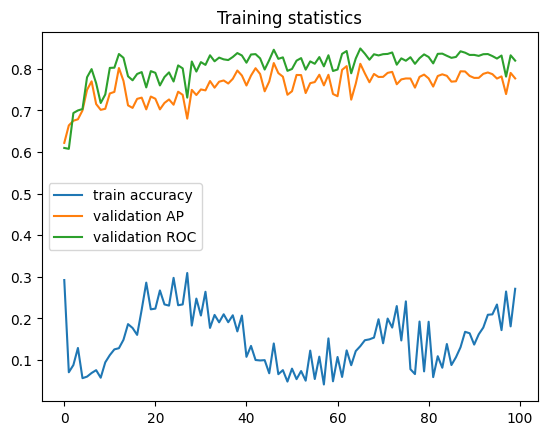

In [11]:
import matplotlib.pyplot as plt

plt.title("Training statistics")
plt.plot(train_accs, label='train accuracy')
plt.plot(val_aps, label='validation AP')
plt.plot(val_rocs, label='validation ROC')
plt.legend(loc="center left")
plt.show()

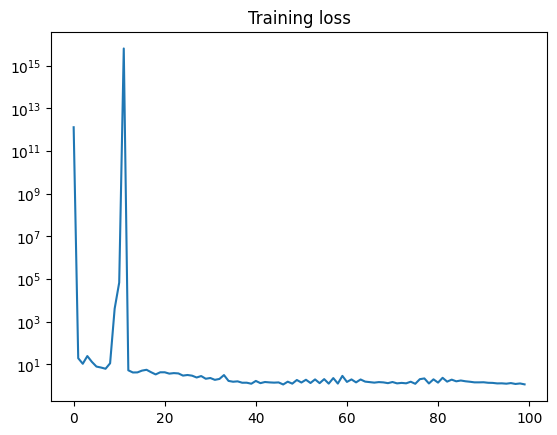

In [12]:
plt.clf()
plt.title('Training loss')
plt.yscale('log')
plt.plot(losses)

In this subject area the most common evaluations are the AUC (area under the ROC curve) and AP (avarage precision).
The AP on the first epoch was close to 50 %, meaning it was almost random, but for the 10th epoch it became 60% (which isn`t too much, but it will be better).

For more evaluation we choose the AUC metric. The reason behind it is, that the most important part of the project is to find all the interactions between drugs correctly if possible. So this metric checks that how precise is an interaction predicted by us. Meaning, if we predicted that between two drugs there is an interaction, what is the chance that there really is one. We chose this because it focuses on the finding more edges correctly, rather than finding non-edges correctly. 
As seen above this metric also went above 50% after a few epochs so it is working correctly. 